# Problem HANGMAN

## Problem statement :
<hr>
 One of the interesting problems in NLP for healthcare is in handling medical coded term associations and spelling errors.So we are going to mimic the problem with hangman / dump charades like NLP word games. Your ML model should predict the correct word from an intentionally obscured word and its description (Hint). Our evaluation set will have incomplete words and their descriptions.
<hr>

## Example
<hr>
Input masked word = DEM_G_A_HY and Description = is the statistical study of populations, especially human beings.
<br>
Model prediction/output = DEMOGRAPHY

### Installing required packages

In [1]:
# !pip install nltk
# !pip install numpy
# !pip install pandas

In [2]:
import nltk

In [3]:
#nltk.download()

### Importing required packages

In [4]:
from nltk.corpus import wordnet
import os
import numpy as np
import pandas as pd

### Setting up directories and getting target words and Training Dataset

In [5]:

curr_dir = os.getcwd()
target_words_dir = 'Targets.txt'
target_txt = open(os.path.join(curr_dir,target_words_dir),"r")

def get_target_words(file_dir):
    target_txt = open(file_dir,"r")
    words = target_txt.readlines()
    return([word[:-1].lower() for word in words])

def get_dataframe(target_words):
    data = {"words":[],"description":[]}
    for word in target_words:
        try:
            synset = wordnet.synsets(word)         
            data["description"].append(synset[0].definition())
            data["words"].append(word)
        except:pass
    return pd.DataFrame(data)

In [6]:
target_words = np.array(get_target_words(target_words_dir))
data = get_dataframe(target_words)

In [7]:
data.head(4)

,words,description
0,kitty,the combined stakes of the betters
1,lookup,an operation that determines whether one or mo...
2,otiose,serving no useful purpose; having no excuse fo...
3,gallant,a man who is much concerned with his dress and...


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords  
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D 
from tensorflow.keras.callbacks import EarlyStopping

## Preprocessing Data

In [9]:
class PreProcess:
    tokenizer = Tokenizer(oov_token="<OOV>")
    max_sequence_len = None

    def __init__(self,corpus):
        self.corpus = self.remove_stop_words(corpus)
        self.tokenizer.fit_on_texts(corpus)
        
    def remove_stop_words(self,data):
        stop_words = set(stopwords.words('english'))
        for i in range(len(data)):
            sent_lst = list(data[i].split(" "))
            sent_lst = filter(lambda x: x not in stop_words, sent_lst)
            data[i] = ' '.join([str(wrd) for wrd in sent_lst])
        return data
            
    def tokenize(self,data):
        data = self.remove_stop_words(data)
        seq = self.tokenizer.texts_to_sequences(data)
        if(self.max_sequence_len == None):self.max_sequence_len = max([len(x) for x in seq])        
        seq_padded = pad_sequences(seq,maxlen=self.max_sequence_len)
        return(seq_padded)
    
    def get_word_index(self):
        return(self.tokenizer.word_index)
    
    def get_seq_length(self):
        return self.max_sequence_len
    
    def get_vocab_length(self):
        return len(self.tokenizer.word_index) + 1
    

## Preprocessing Meaning of the words

In [10]:
pre_pro_X = PreProcess(data['description'])
X = np.array(pre_pro_X.tokenize(data['description']))

max_seq_length = pre_pro_X.get_seq_length()
vocab_length = pre_pro_X.get_vocab_length()
#print(max_seq_length)

## Preprocessing the Labels

In [11]:
pre_pro_y = PreProcess(data['words'])
y = np.array(pre_pro_y.tokenize(data['words']))

total_target_words = pre_pro_y.get_vocab_length()
ys = tf.keras.utils.to_categorical(y, num_classes=total_target_words)


##  LSTM Model 

In [21]:
model = Sequential()

## Embedding Layer
model.add(Embedding(vocab_length, 100, input_length=36))

## Dropout Layer
model.add(SpatialDropout1D(0.2))

## LSTM Layer
model.add(Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2)))

## Output Layer
model.add(Dense(total_target_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="ADAM",metrics=['accuracy'])

In [49]:
earlystop = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X, ys, epochs=3, verbose=1,callbacks=[earlystop])

Epoch 1/3
672/672 [==============================] - 80s 119ms/step - loss: 0.9942 - accuracy: 0.7926
Epoch 2/3
672/672 [==============================] - 77s 115ms/step - loss: 0.8855 - accuracy: 0.7979
Epoch 3/3
672/672 [==============================] - 80s 119ms/step - loss: 0.8267 - accuracy: 0.8016


## Model Summary

In [ ]:
print(model.summary())

## Saving the Model

In [ ]:
model.save('LSTM')

## Loading the Model

In [ ]:
model = tf.keras.load_model("LSTM")

## Model Evaluation

In [50]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

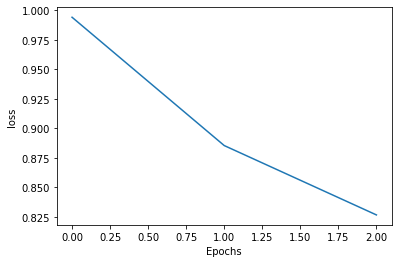

In [51]:
plot_graphs(history, 'loss')

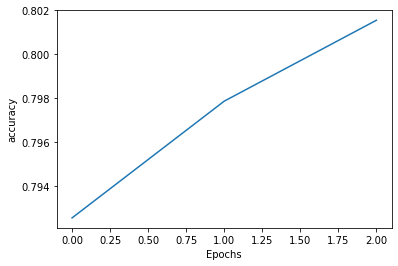

In [52]:
plot_graphs(history,'accuracy')

## Predicting for Test Data

In [36]:
class Predict:
    
    def __init__(self,target_words,model,pre_pro_X,pre_pro_y):
        self.target_words =  target_words
        self.model        =  model
        self.pre_pro_X    =  pre_pro_X
        self.pre_pro_y    =  pre_pro_y
        
    def get_words_set(self,pred_word,dashed,wrd_len):
        words_set = filter(lambda word : nltk.edit_distance(word, pred_word) ==  dashed and wrd_len ==  len(word),
                          self.target_words)
        return words_set
        
    def predict_word(self,wrd,preds):
        wrd_lst = wrd.split(" ")
        wrd_conv = ''.join(x for x in filter(lambda x: x!='_', wrd_lst))
        
        words_set = self.get_words_set(wrd_conv,wrd_lst.count('_'),len(wrd_lst))
        
        target_wrds_set = list(self.pre_pro_y.tokenizer.word_index.keys())
        target_wrds_inxs, selective_preds = [],[]

        for word in words_set:
            try:target_wrds_inxs.append(word)
            except:pass    

        for inx in target_wrds_inxs:
            try:selective_preds.append(preds[target_wrds_set.index(inx)])
            except:pass

        try:
            max_prob = max(selective_preds)
        except:
            return None;
        
        return(target_wrds_set[preds.index(max_prob)])
                
    
    def predict_words(self,words_dataframe):
        final_preds = {"Masked":[],"preds":[],"description":[]}
        
        for index,row in words_dataframe.iterrows():
            final_preds["Masked"].append(row["Masked"])
            final_preds["description"].append(row["Meaning"])
            
            test_desc_encoded = self.pre_pro_X.tokenize([row['Meaning']])
            preds = list(self.model.predict(test_desc_encoded).reshape(-1))
            
            final_preds["preds"].append(self.predict_word(row["Masked"],preds))
        
        return final_preds
                   

In [37]:
predict = Predict(target_words, model, pre_pro_X, pre_pro_y)
test_df = pd.read_csv("eval.csv")
preds_test = pd.DataFrame(predict.predict_words(test_df))

In [42]:
type(preds_test)

pandas.core.frame.DataFrame

In [43]:
from IPython.display import display

In [47]:
display(preds_test.tail(10))

,Masked,preds,description
241,_ e r n _,learn,French writer who is considered the father of ...
242,c o _ m _ n t,comment,a statement that expresses a personal opinion ...
243,_ _ a y e _ f u l,prayerful,disposed to pray or appearing to pray
244,_ a p a _ _ _ a t e,capacitate,make legally capable or qualify in law
245,b _ u t,butt,(sports
246,H i c _ e _,0,a small inflamed elevation of the skin; a pust...
247,n o,0,a negative
248,s o l _ e _ t,solvent,a liquid substance capable of dissolving other...
249,_ u m p _,grump,resembling a garbage dump
250,c o _ _ i _ a t _ o n,compilation,something that is compiled (as into a single b...


## Saving the Predictions